In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

In [2]:
df = pd.read_csv('data/data1.csv')
df = df.set_index('Date').rename_axis('Adj. Close', axis=1)
df = df.iloc[:,[2,5,7,9,10,3,0,4,8,1,6]]

ll = -100*(np.log(df)-np.log(df.shift(1)))
ll = ll.iloc[1:]
ll = ll.rename_axis('Loss', axis=1)

sectors = [x[4:] for x in ll.columns]
sectors = [x.replace(' ','\n') for x in sectors]

In [3]:
# Color Map
c1 = "#636EFA"
c2 = "#EF553B"
c3 = "#00CC96"
c4 = "#AB63FA"
c5 = "#FECB52"

label = [c1,c1,c2,c2,c2,c2,c3,c3,c4,"grey",c5]
cluster = [1,1,0,0,0,0,2,2,3,4,5]
nodes = [(sectors[i],{'color': label[i], 'subset': cluster[i]}) for i in range(11)]

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF

def chi(x,y):
    
    m = 25
    n = m*(len(x)//m)
    
    z1 = x.iloc[:n].groupby(x.iloc[:n].reset_index().index // m).max()
    z2 = y.iloc[:n].groupby(y.iloc[:n].reset_index().index // m).max()
    
    g1 = ECDF(z1)
    g2 = ECDF(z2)
    
    nu = 0.5*np.mean(np.abs(g1(z1)-g2(z2)))
    chi = 2-(1+2*nu)/(1-2*nu)
    
    return chi

In [5]:
chi_matrix = []

for i in range(11):
    chi_matrix.append([])
    for j in range(11):
        chi_matrix[i].append(chi(ll.iloc[:,i],ll.iloc[:,j]))
        
chi_matrix = pd.DataFrame(chi_matrix, index=sectors, columns=sectors)

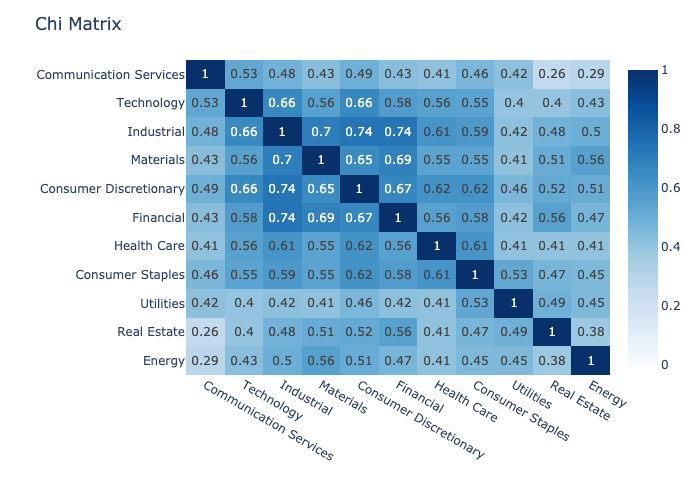

In [6]:
px.imshow(chi_matrix.round(2), color_continuous_scale='Blues', range_color=[0,1], text_auto=True, aspect='auto').update_layout(
    title='Chi Matrix',
    xaxis_title='', yaxis_title='',
    width=700
)

In [7]:
G = nx.Graph()
G.add_nodes_from(nodes)

for i in range(11):
    for j in range(i+1,11):
        G.add_edge(sectors[i], sectors[j], weight=chi_matrix.iloc[i,j])
        
chi7 = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.7]
chi6 = [(u, v) for (u, v, d) in G.edges(data=True) if ((d['weight'] > 0.6) & (d['weight'] <= 0.7))]
chi5 = [(u, v) for (u, v, d) in G.edges(data=True) if ((d['weight'] > 0.5) & (d['weight'] <= 0.6))]
chi4 = [(u, v) for (u, v, d) in G.edges(data=True) if ((d['weight'] > 0.4) & (d['weight'] <= 0.5))]

pos = nx.spring_layout(G, seed=7)

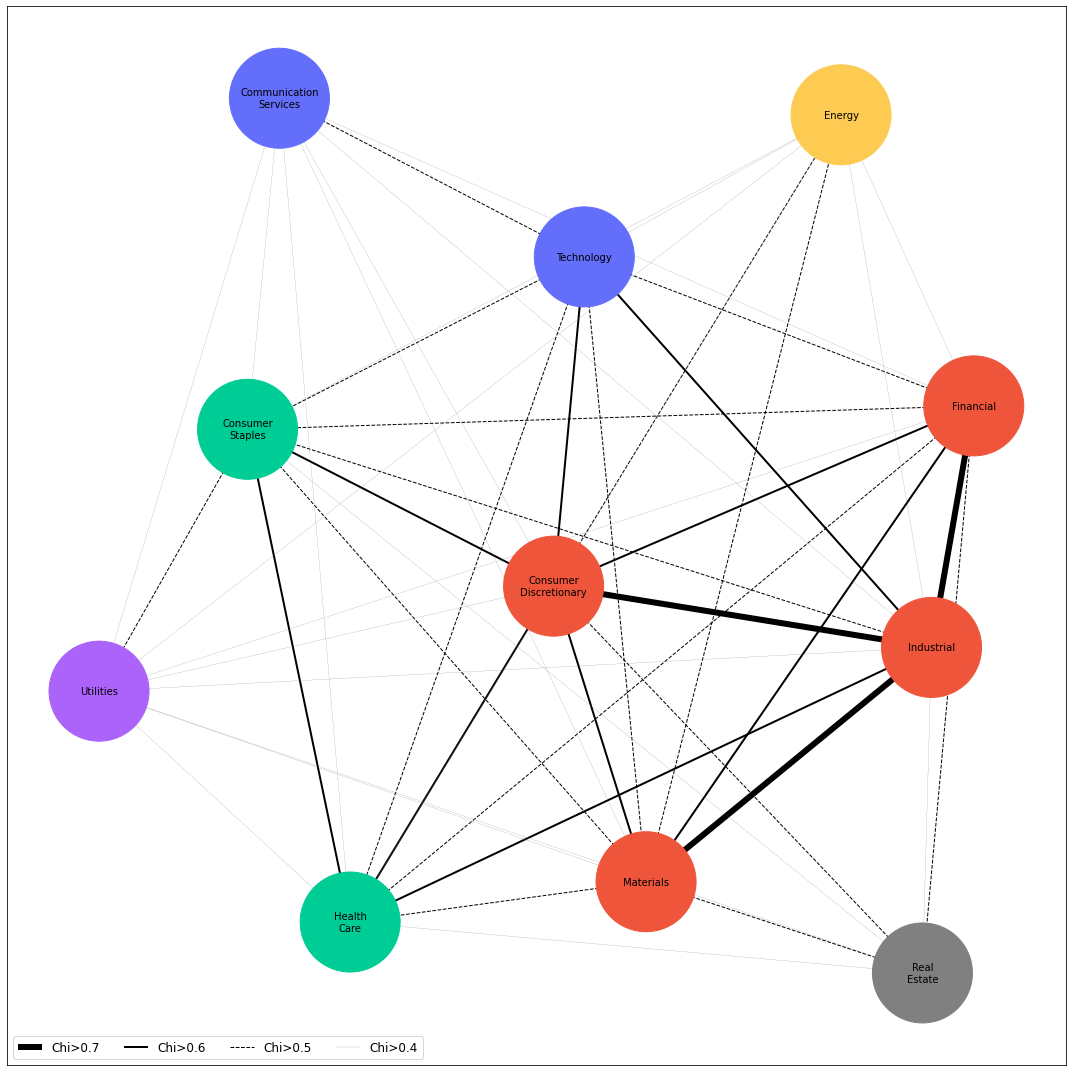

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(
    G, pos, node_shape='o', node_size=1e4,
    node_color=[G.nodes[sectors[i]]['color'] for i in range(11)]
)

nx.draw_networkx_labels(G, pos, font_size=10)

nx.draw_networkx_edges(G, pos, edgelist=chi7, width=6, label='Chi>0.7')
nx.draw_networkx_edges(G, pos, edgelist=chi6, width=2, label='Chi>0.6')
nx.draw_networkx_edges(G, pos, edgelist=chi5, width=1, style='dashed', label='Chi>0.5')
nx.draw_networkx_edges(G, pos, edgelist=chi4, width=0.2, edge_color='grey', label='Chi>0.4')

plt.legend(loc='lower left', ncol=4, fontsize=12)
plt.tight_layout()
plt.savefig('figures/chi_network.jpeg', dpi=100)
plt.show()